In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import math
import random

from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input
from keras.layers import Conv2D, MaxPooling2D, concatenate
from keras.callbacks import ModelCheckpoint
from keras.optimizers import RMSprop, Adam, Adadelta
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras_squeezenet import SqueezeNet

from textwrap import wrap
import matplotlib.image as mpimg
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
%matplotlib inline
DIRECTORY = '/home/joe/Dev/robot/Human Pilot Batch 2'
CSV_FILE = '/home/joe/Dev/robot/human_pilot_batch_2_labels.csv'
filenames = os.listdir(DIRECTORY)
df = pd.read_csv(CSV_FILE)
width_height = 224
BATCH_SIZE = 175
np.random.seed(42)

Using TensorFlow backend.


In [2]:
def load_image(filename1, filename2, filename3, filename4, folder=DIRECTORY):
    img1 = cv2.imread('{}/{}'.format(folder, filename1))
    img2 = cv2.imread('{}/{}'.format(folder, filename2))
    img3 = cv2.imread('{}/{}'.format(folder, filename3))
    img4 = cv2.imread('{}/{}'.format(folder, filename4))
    img1 = cv2.resize(img1, (112, 112))
    img2 = cv2.resize(img2, (112, 112))
    img3 = cv2.resize(img3, (112, 112))
    img4 = cv2.resize(img4, (112, 112))

    output = np.zeros((225, 225, 3))
    output[0:112,0:112] = img1
    output[113:225,0:112] = img2
    output[0:112,113:225] = img3
    output[113:225,113:225] = img4
    return output[0:224,0:224]

def mean_normalize(img):
    return (img - img.mean()) / (img.max() - img.min())

def normalize(img):
    return img / 255

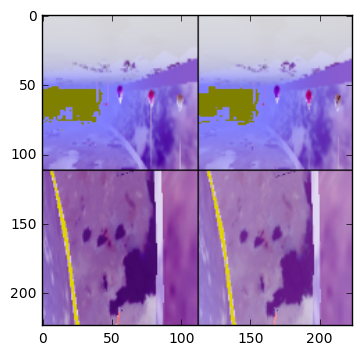

In [3]:
#hmnfwdL48.png hmndwnL48.png hmnfwdL49.png hmndwnL49.png
filename1 = 'hmnfwdL48.png'
filename2 = 'hmndwnL48.png'
filename3 = 'hmnfwdL49.png'
filename4 = 'hmndwnL49.png'
img = load_image(filename1, filename2, filename3, filename4)
plt.imshow(img)

In [4]:
def get_x_data(images_df, positions_df, num_rows):
    #images4 = pd.DataFrame(columns=['filename1','filename2','filename3','filename4'])
    x_data = []
    #x = positions_df.values
    min_max_scaler = preprocessing.MinMaxScaler()
    scaled = min_max_scaler.fit_transform(positions_df)*.6
    scaled = scaled + .2
    #x_pos_df = pd.DataFrame(scaled)
    for i in range(0, num_rows-1):
        dict_images = {'filename1': images_df[i][0], 'filename2': images_df[i][1],
                       'filename3': images_df[i+1][0], 'filename4': images_df[i+1][1],
                       'position.x': scaled[i][0],
                       'position.y': scaled[i][1],
                       'position.z': scaled[i][2],
                       'rotation.y': scaled[i][3]}
        x_data.append(dict_images)
    df_x_data = pd.DataFrame(x_data, columns=['filename1', 'filename2', 'filename3', 'filename4',
                                                    'position.x', 'position.y', 'position.z', 'rotation.y'])
    return df_x_data


In [5]:
num_rows = len(df.index)
images_df = df[['filename1','filename2']].values
positions_df = df[['position.x','position.y','position.z','rotation.y']].values
get_x_data(images_df, positions_df, num_rows)

,filename1,filename2,filename3,filename4,position.x,position.y,position.z,rotation.y
0,hmnfwdB1.png,hmndwnB1.png,hmnfwdB2.png,hmndwnB2.png,0.799996,0.781328,0.200000,0.775681
1,hmnfwdB2.png,hmndwnB2.png,hmnfwdB3.png,hmndwnB3.png,0.800000,0.798746,0.200022,0.732842
2,hmnfwdB3.png,hmndwnB3.png,hmnfwdB4.png,hmndwnB4.png,0.798986,0.800000,0.200302,0.732558
3,hmnfwdB4.png,hmndwnB4.png,hmnfwdB5.png,hmndwnB5.png,0.797972,0.799664,0.200584,0.732274
4,hmnfwdB5.png,hmndwnB5.png,hmnfwdB6.png,hmndwnB6.png,0.797004,0.799559,0.200854,0.732003
5,hmnfwdB6.png,hmndwnB6.png,hmnfwdB7.png,hmndwnB7.png,0.796117,0.798534,0.201103,0.731861
6,hmnfwdB7.png,hmndwnB7.png,hmnfwdB8.png,hmndwnB8.png,0.795266,0.798084,0.201342,0.731793
7,hmnfwdB8.png,hmndwnB8.png,hmnfwdB9.png,hmndwnB9.png,0.794450,0.796658,0.201571,0.731923
8,hmnfwdB9.png,hmndwnB9.png,hmnfwdB10.png,hmndwnB10.png,0.793659,0.794533,0.201793,0.732143
9,hmnfwdB10.png,hmndwnB10.png,hmnfwdB11.png,hmndwnB11.png,0.792900,0.792459,0.202005,0.732354


In [6]:
def get_y_data(positions_df, num_rows):
    y_data = []
    for i in range(0, num_rows-1):
        dict_images = {'position.x': positions_df[i+1][0], 'position.y': positions_df[i+1][1],
                       'position.z': positions_df[i+1][2], 'rotation.y': positions_df[i+1][3],
                       'pos_delta.x': positions_df[i+1][0] - positions_df[i][0],
                       'pos_delta.y': positions_df[i+1][1] - positions_df[i][1],
                       'pos_delta.z': positions_df[i+1][2] - positions_df[i][2],
                       'rot_delta.y': positions_df[i+1][3] - positions_df[i][3]}
        y_data.append(dict_images)
    df_y_data = pd.DataFrame(y_data, columns=['position.x', 'position.y', 'position.z', 'rotation.y',
                                                    'pos_delta.x', 'pos_delta.y', 'pos_delta.z', 'rot_delta.y'])
    return df_y_data

In [7]:
get_y_data(positions_df, num_rows)

,position.x,position.y,position.z,rotation.y,pos_delta.x,pos_delta.y,pos_delta.z,rot_delta.y
0,-0.011348,-1.037615,-27.996341,1.203576,0.000217,0.108363,0.001685,-0.220588
1,-0.067048,-1.029816,-27.974923,1.202118,-0.055701,0.007799,0.021417,-0.001458
2,-0.122802,-1.031903,-27.953392,1.200656,-0.055754,-0.002087,0.021531,-0.001462
3,-0.175968,-1.032559,-27.932770,1.199261,-0.053166,-0.000656,0.020621,-0.001395
4,-0.224733,-1.038936,-27.913778,1.198529,-0.048765,-0.006377,0.018993,-0.000732
5,-0.271489,-1.041736,-27.895528,1.198178,-0.046755,-0.002800,0.018249,-0.000351
6,-0.316334,-1.050605,-27.878007,1.198846,-0.044845,-0.008869,0.017522,0.000668
7,-0.359759,-1.063825,-27.861073,1.199977,-0.043425,-0.013219,0.016934,0.001131
8,-0.401463,-1.076730,-27.844866,1.201063,-0.041704,-0.012906,0.016208,0.001086
9,-0.439002,-1.088336,-27.830324,1.202040,-0.037539,-0.011606,0.014542,0.000977


In [8]:
def get_class_weights():
    data = get_y_data(positions_df, num_rows)
    max_val = data.max(axis=0)
    min_val = data.min(axis=0)
    delta = max_val - min_val
    class_weights = (1.0 / delta.values)/ 8
    return class_weights
#get_class_weights()

In [9]:
X = get_x_data(images_df, positions_df, num_rows).values
y = get_y_data(positions_df, num_rows).values
print(X)

[['hmnfwdB1.png' 'hmndwnB1.png' 'hmnfwdB2.png' ..., 0.7813279191038247 0.2
  0.775681287342963]
 ['hmnfwdB2.png' 'hmndwnB2.png' 'hmnfwdB3.png' ..., 0.7987463234120677
  0.2000220592641225 0.7328415434567725]
 ['hmnfwdB3.png' 'hmndwnB3.png' 'hmnfwdB4.png' ..., 0.8 0.2003024005612349
  0.7325583810190954]
 ..., 
 ['hmnfwdU1218.png' 'hmndwnU1218.png' 'hmnfwdU1219.png' ...,
  0.6362842787143869 0.7992435683392847 0.3468463933619869]
 ['hmnfwdU1219.png' 'hmndwnU1219.png' 'hmnfwdU1220.png' ...,
  0.6351125954470203 0.7998576640386039 0.335888175141537]
 ['hmnfwdU1220.png' 'hmndwnU1220.png' 'hmnfwdU1221.png' ...,
  0.6318806872565839 0.7999518373179895 0.3057703292391373]]


In [10]:
n_features = 1
n_classes = y.shape[1]

X, y = shuffle(X, y)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

print('We\'ve got {} feature rows and {} labels'.format(len(X_train), len(y_train)))
print('Each row has {} features'.format(n_features))
print('and we have {} classes'.format(n_classes))
assert(len(y_train) == len(X_train))
print('We use {} rows for training and {} rows for validation'.format(len(X_train), len(X_valid)))
print('So far, so good')

We've got 1679 feature rows and 1679 labels
Each row has 1 features
and we have 8 classes
We use 1679 rows for training and 89 rows for validation
So far, so good


First, I am going to 

In [11]:

images = Input(shape=(224,224,3),name = 'image_input')
positions = Input(shape=(4,),name = 'position_input')
inception_v3_model = InceptionV3(weights='imagenet', include_top=False)
for layer in inception_v3_model.layers:
    layer.trainable=False
inception_v3_model.summary()

#Use the generated model 
inception_v3_model_conv = inception_v3_model(images)
#forward = GlobalAveragePooling2D()(inception_v3_model_conv)
cnn = GlobalAveragePooling2D()(inception_v3_model_conv)
final = concatenate([cnn, positions])    #forward
final = Dense(1024,activation="relu")(final)
final = Dropout(0.5)(final)
final = Dense(1024,activation="relu")(final)
final = Dropout(0.5)(final)
final = Dense(8, activation='linear')(final)

#Create model 
model = Model(input=[images, positions], output=final)

#In the summary, weights and layers from InceptionV3 part will be hidden, but they will be fit during the training
model.summary()
#model.add(Dense(2,1,init=’uniform’, activation=’linear’))
#model.compile(loss='mse', optimizer='rmsprop')
adam = Adam(lr=0.001, clipvalue=1.5)
model.compile(loss='mse', optimizer=adam)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, None, None, 32 864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, None, None, 32 96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, None, None, 32 0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

/home/joe/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


In [12]:
def generator(X, y, batch_size=BATCH_SIZE):
    X_copy, y_copy = X, y
    while True:
        #print(len(X_copy))
        for i in range(0, len(X_copy), batch_size):
            X_image, X_positions, y_result = [], [], []
            if i<len(X_copy):
                for x, y in zip(X_copy[i:i+batch_size], y_copy[i:i+batch_size]):
                    rx1, rx2, ry = [normalize(load_image(x[0], x[1], x[2], x[3]))], [x[4] + random.gauss(0, .08)
                                                                                     ,x[5] + random.gauss(0, .08)
                                                                                     ,x[6] + random.gauss(0, .08)
                                                                                     ,x[7] + random.gauss(0, .08)
                                                                                    ], [y]
                    #print(x[0], x[1], x[2], x[3])
                    y = np.array(ry)
                    X_image.append(rx1)
                    X_positions.append([rx2])
                    y_result.append(y)
                X_result_1, X_result_2, y_result = np.concatenate(X_image), np.concatenate(X_positions), np.concatenate(y_result)
                yield [X_result_1, X_result_2], y_result
                #print(y_result)
                #yield X_result_1, y_result
        #X_copy, y_copy = shuffle(X_copy, y_copy)

In [13]:
gen = generator(X_train, y_train)

In [ ]:

test_x, test_y = next(gen)
print(test_x)
print(test_x.shape)

In [14]:
EPOCHS = 20
PER_EPOCH = 4

class_w = get_class_weights()
filepath="/home/joe/Dev/robot/models/InceptionV3_fc512_X2_pos-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=True)
callbacks_list = [checkpoint]

history = model.fit_generator(
    generator(X_train, y_train),
    steps_per_epoch=PER_EPOCH,
    epochs=EPOCHS,
    validation_data=generator(X_valid, y_valid),
    #validation_steps=len(y_valid)//(BATCH_SIZE),
    #class_weight = class_w,
    validation_steps=1,
    callbacks=callbacks_list
)

Epoch 1/20
4/4 [==============================] - 412s - loss: 72.4023 - val_loss: 79.7041
Epoch 2/20
4/4 [==============================] - 457s - loss: 43.5243 - val_loss: 35.9040
Epoch 3/20
4/4 [==============================] - 401s - loss: 34.6426 - val_loss: 59.8954
Epoch 4/20
4/4 [==============================] - 460s - loss: 24.2903 - val_loss: 22.0909
Epoch 5/20
4/4 [==============================] - 394s - loss: 18.2713 - val_loss: 29.0551
Epoch 6/20
4/4 [==============================] - 425s - loss: 16.6565 - val_loss: 20.8198
Epoch 7/20
4/4 [==============================] - 390s - loss: 13.6927 - val_loss: 26.3675
Epoch 8/20
4/4 [==============================] - 372s - loss: 12.9719 - val_loss: 21.7761
Epoch 9/20
4/4 [==============================] - 394s - loss: 11.3852 - val_loss: 23.5743
Epoch 10/20
4/4 [==============================] - 380s - loss: 9.4572 - val_loss: 23.2147
Epoch 11/20
4/4 [==============================] - 430s - loss: 9.3136 - val_loss: 23.9293

In [15]:
list_X_valid = list(X_valid)
list_y_valid = list(y_valid)
for i in range(0, len(list_X_valid)):
    list_fil = list(list_X_valid[i])
    print('')
    print('')
    print(i)
    print('actual pos: ', list_y_valid[i])
#    print('image1: ', list_fil[0])
#    print('image2: ', list_fil[1])
#    print('image3: ', list_fil[2])
#    print('image4: ', list_fil[3])
    img = normalize(load_image(list_fil[0], list_fil[1], list_fil[2], list_fil[3]))
    '''
   # display(
  #  sample_images,
 #   cols=1#,
    #titles=[t for t in samples['filename1']]
#)
'''
#    pre_img = preprocess(img)
    pre_img = img.reshape((1, width_height, width_height, 3))
#    print(pre_img.shape)
    positions = np.asarray([list_fil[4], list_fil[5], list_fil[6], list_fil[7]])
    positions = positions.reshape(1,4)
    predicted = model.predict([pre_img,positions])
    print('')
    print('predicted: ', predicted)
    print('')



0
actual pos:  [ -2.74843902e+01  -2.17257372e+00  -1.61586935e+01   5.53292394e-01
  -2.87897579e-02   2.01397870e-03   4.66169440e-02   1.91525200e-04]

predicted:  [[ -3.58887825e+01  -3.48502636e+00  -1.19347095e+01   2.38104165e-01
   -1.03322655e-01  -1.35348300e-02   1.00816317e-01  -2.60722637e-01]]



1
actual pos:  [ -2.22119911e+01  -2.25789890e+00   1.56890473e+01  -6.50642633e-01
   3.14315322e-02   6.03702840e-03   4.04263557e-02   1.00289041e-02]

predicted:  [[ -2.38827171e+01  -2.72212672e+00   9.10955906e+00  -3.30073908e-02
    1.86297596e-01   5.99266123e-03  -4.35781665e-02  -3.33069153e-02]]



2
actual pos:  [ -3.25950104e+01  -3.28604130e+00   1.23441728e+01  -1.27715588e+00
   4.44219454e-02  -1.45706713e-02   1.35712138e-02  -4.60602080e-03]

predicted:  [[ -4.00407791e+01  -4.52811718e+00   1.02590113e+01  -6.27170950e-02
    3.83365393e-01   3.86362731e-01  -1.08007669e-01  -3.34715582e-02]]



3
actual pos:  [ -2.08421158e+01  -2.06044399e+00  -2.00989951